In [52]:
import json
import pandas as pd

## Loading and processing the datasets

In [54]:
def load_data(csv_path, nrows=None):
    """
    Load and preprocess the Google Analytics customer revenue dataset.
    
    Parameters:
        csv_path (str): Path to the CSV file.
        nrows (int, optional): Number of rows to load for testing purposes. Loads all rows if None.
        
    Returns:
        pd.DataFrame: Processed DataFrame with flattened JSON columns and formatted data.
    """
    
    # Define columns that contain JSON data
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Load the CSV file with JSON columns parsed and fullVisitorId as a string
    df = pd.read_csv(
        csv_path,
        converters={column: json.loads for column in JSON_COLUMNS},  # Convert JSON columns to dictionaries
        dtype={'fullVisitorId': 'str'},  # Ensure fullVisitorId is loaded as a string for uniqueness
        nrows=nrows  # Load specified number of rows if provided
    )
    
    # Flatten each JSON column and merge back into the main DataFrame
    for column in JSON_COLUMNS:
        # Convert JSON data in the column to a DataFrame
        column_as_df = pd.json_normalize(df[column])
        
        # Rename the columns to indicate their source (e.g., device_isMobile)
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        
        # Drop the original JSON column and merge the new flattened columns
        df = df.drop(column, axis=1).join(column_as_df)
    
    # Drop columns that are either not useful or too complex for initial analysis
    df.drop(columns=['customDimensions', 'hits'], inplace=True)
    
    # Fill missing values for key numerical columns with 0
    # - totals_pageviews: Number of pages viewed in a session, can be 0 if no pages were viewed
    # - totals_transactionRevenue: Revenue generated, fill missing with 0 as no revenue
    df.fillna({
        'totals_pageviews': 0,
        'totals_transactionRevenue': 0
    }, inplace=True)
    
    # Convert specific columns to integers for consistency
    df['device_isMobile'] = df['device_isMobile'].astype(int)  # Convert isMobile to 1 or 0
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)  # Revenue as integer
    
    # Ensure all object (string) columns are consistently treated as strings
    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].astype(str)
    
    return df


In [56]:
# Load a subset (100,000 rows) of the data for testing purposes
df = load_data('../data/raw/dataset.csv', nrows=1000000)

# Inspect the first few rows to confirm the processing
display(df.head())

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,...,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,nan,nan,nan,nan,nan,nan,nan,nan
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan,nan
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [58]:
df.shape

(1000000, 58)

## Exploratory Data Analysis (EDA)

### Initial Data Overview

In [61]:
# Overview of data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 58 columns):
 #   Column                                             Non-Null Count    Dtype 
---  ------                                             --------------    ----- 
 0   channelGrouping                                    1000000 non-null  object
 1   date                                               1000000 non-null  int64 
 2   fullVisitorId                                      1000000 non-null  object
 3   socialEngagementType                               1000000 non-null  object
 4   visitId                                            1000000 non-null  int64 
 5   visitNumber                                        1000000 non-null  int64 
 6   visitStartTime                                     1000000 non-null  int64 
 7   device_browser                                     1000000 non-null  object
 8   device_browserVersion                              1000000 non-null  obje

In [63]:
# Summary statistics of numeric columns
df.describe()

,date,visitId,visitNumber,visitStartTime,device_isMobile,totals_transactionRevenue
count,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06
mean,2.016966e+07,1.497377e+09,2.315454,1.497377e+09,0.311362,1.325589e+06
std,6.541047e+03,1.634101e+07,9.210633,1.634101e+07,0.463051,4.613213e+07
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,0.000000,0.000000e+00
25%,2.016120e+07,1.480951e+09,1.000000,1.480951e+09,0.000000,0.000000e+00
50%,2.017062e+07,1.498168e+09,1.000000,1.498168e+09,0.000000,0.000000e+00
75%,2.017113e+07,1.511974e+09,1.000000,1.511974e+09,1.000000,0.000000e+00
max,2.018043e+07,1.525072e+09,457.000000,1.525072e+09,1.000000,2.312950e+10


In [65]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


### Explore Target Variable (`totals_transactionRevenue`)

In [70]:
# Calculate total revenue per user
user_revenue = df.groupby('fullVisitorId')['totals_transactionRevenue'].sum()

python(30075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


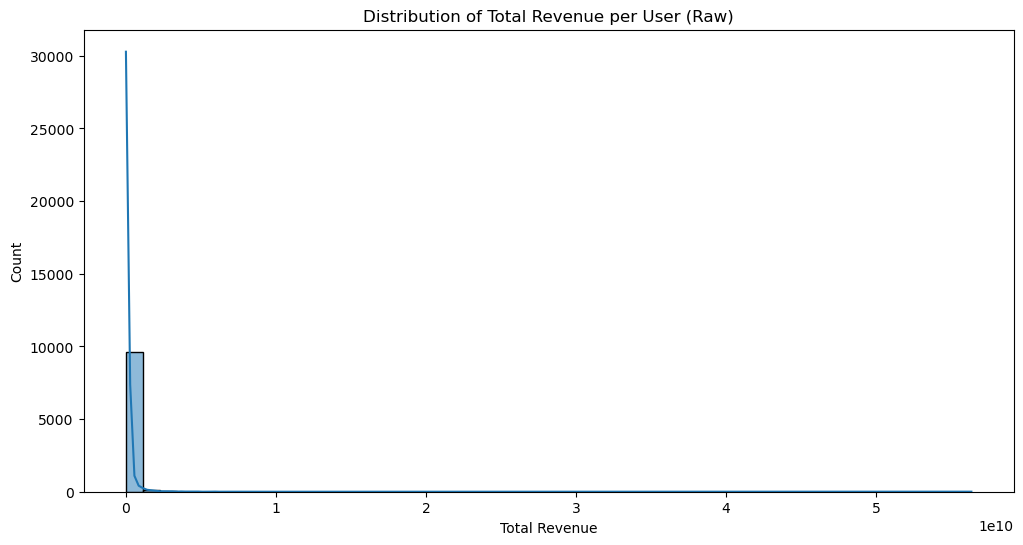

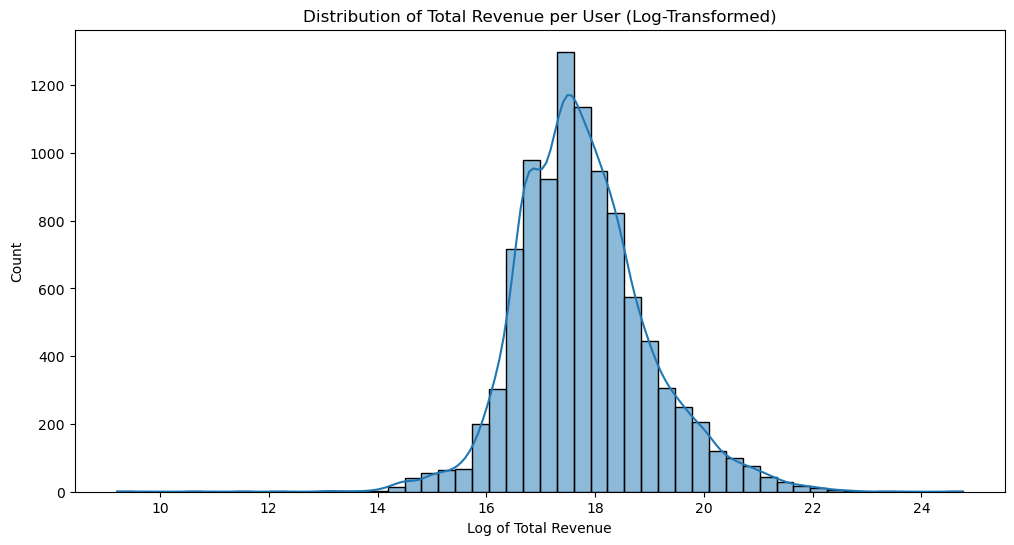

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot histogram of the total revenue
plt.figure(figsize=(12, 6))
sns.histplot(user_revenue[user_revenue > 0], bins=50, kde=True)
plt.title("Distribution of Total Revenue per User (Raw)")
plt.xlabel("Total Revenue")
plt.show()

# Plot histogram of log-transformed revenue
log_user_revenue = np.log1p(user_revenue[user_revenue > 0])
plt.figure(figsize=(12, 6))
sns.histplot(log_user_revenue, bins=50, kde=True)
plt.title("Distribution of Total Revenue per User (Log-Transformed)")
plt.xlabel("Log of Total Revenue")
plt.show()